In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import random
import glob
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import h5py
import pandas as pd

In [ ]:
# シード
seed = 408
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
class Transform():
    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.8, 1.0), ratio=(4/5, 5/4)),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.ToTensor()
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.ToTensor()
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [ ]:
def make_datapath_list():
    rootpath = '../images/Resized_64/'
    target_path = rootpath + '*/*.jpg'
    print(target_path)
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [ ]:
def read_h5p(img_path, dir='/content/drive/My Drive/local/Face-Recognition/images/FaceData.h5'):
    imgs = []
    with h5py.File(dir, mode='r') as h5:
        for path in imgs_path:
            img = h5['%s'%(path)]
            img = np.array(img)
            imgs.append(Image.fromarray(img))
    return imgs

In [ ]:
class FaceDataset(data.Dataset):
    def __init__(self, file_list, labels, transform=None, phase='train'):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        img_path = self.file_list[index]
        img = self.read_h5(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = self.labels[index]
        
        return img_transformed, label
        
    def read_h5(self, path, dir='/content/drive/My Drive/local/Face-Recognition/images/FaceData.h5'):
        with h5py.File(dir, mode='r') as f:
            img = f[r'{}'.format(path)]
            img = np.array(img)
            img = Image.fromarray(img)
        return img
    

In [ ]:
default_path = '/content/drive/My Drive/local/Face-Recognition/'
csv = pd.read_csv(default_path + 'images/FaceData.csv')
# 最後のデータがきれいでなかったため削除
csv = csv[:3308]
img_path = csv['path'].to_list()
labels = csv['labels'].to_list()

In [ ]:
path_train, path_val, label_train, label_val = train_test_split(img_path, labels, test_size=0.2)
size = 64
transform = Transform(size)

torch.Size([3, 64, 64])


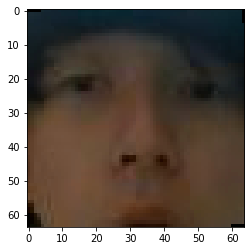

1


In [ ]:
train_dataset = FaceDataset(path_train, label_train, Transform(size), phase='train')
val_dataset = FaceDataset(path_val, label_val, Transform(size), phase='val')
index = np.random.randint(0, 3000)
print(train_dataset.__getitem__(index)[0].size())
transformed_img = train_dataset.__getitem__(index)[0]
transformed_img = transformed_img.numpy().transpose((1, 2, 0))
plt.imshow(transformed_img)
plt.show()
print(train_dataset.__getitem__(index)[1])

In [ ]:
# ミニバッチサイズ
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 64, 64])
tensor([1, 5, 3, 2, 1, 5, 4, 5, 3, 4, 4, 0, 0, 4, 0, 4, 5, 3, 5, 0, 5, 0, 4, 3,
        5, 0, 5, 5, 3, 1, 4, 1])


In [ ]:
class EaseClassificationModel(nn.Module):

    def __init__(self, H, W):
        super(EaseClassificationModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128 * (H//4) * (W//4), 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('使用デバイス : ', device)
    model.to(device)
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('---------------')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            epoch_loss = 0.0
            epoch_corrects = 0

            for i, data in enumerate(dataloaders_dict[phase]):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                print('\rNo, %d' % i, end='')
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs,labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計
                    epoch_corrects += torch.sum(preds == labels.data)
            print(outputs[0])

            # epochごとの結果の計算
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [ ]:
model = EaseClassificationModel(size, size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=1e-2)
num_epochs = 100
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs)

使用デバイス :  cuda:0
Epoch 1/100
---------------
No, 82tensor([0.1671, 0.1797, 0.1665, 0.1686, 0.1493, 0.1688], device='cuda:0',
       grad_fn=<SelectBackward>)
train Loss: 1.7922 Acc: 0.1455
No, 20tensor([0.1664, 0.1806, 0.1671, 0.1690, 0.1490, 0.1679], device='cuda:0')
val Loss: 1.7910 Acc: 0.1616
Epoch 2/100
---------------
No, 82tensor([0.1655, 0.1790, 0.1652, 0.1690, 0.1470, 0.1743], device='cuda:0',
       grad_fn=<SelectBackward>)
train Loss: 1.7904 Acc: 0.1988
No, 20tensor([0.1660, 0.1760, 0.1651, 0.1677, 0.1462, 0.1790], device='cuda:0')
val Loss: 1.7888 Acc: 0.2840
Epoch 3/100
---------------
No, 82tensor([0.1707, 0.1576, 0.1558, 0.1587, 0.1353, 0.2219], device='cuda:0',
       grad_fn=<SelectBackward>)
train Loss: 1.7874 Acc: 0.3054
No, 20tensor([0.1665, 0.1668, 0.1606, 0.1638, 0.1392, 0.2030], device='cuda:0')
val Loss: 1.7840 Acc: 0.2946
Epoch 4/100
---------------
No, 82tensor([0.1542, 0.1016, 0.1123, 0.1254, 0.0884, 0.4182], device='cuda:0',
       grad_fn=<SelectBackward>)

In [ ]:
model = EaseClassificationModel(size, size)
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
output = model(inputs)
print(output)
print(labels)

tensor([[0.1662, 0.1497, 0.1565, 0.1710, 0.1848, 0.1718],
        [0.1660, 0.1499, 0.1564, 0.1712, 0.1848, 0.1717],
        [0.1660, 0.1498, 0.1563, 0.1710, 0.1850, 0.1719],
        [0.1660, 0.1499, 0.1564, 0.1710, 0.1848, 0.1719],
        [0.1661, 0.1496, 0.1565, 0.1711, 0.1848, 0.1719],
        [0.1661, 0.1499, 0.1564, 0.1709, 0.1848, 0.1718],
        [0.1660, 0.1498, 0.1564, 0.1710, 0.1849, 0.1719],
        [0.1660, 0.1498, 0.1565, 0.1712, 0.1846, 0.1719],
        [0.1664, 0.1497, 0.1563, 0.1710, 0.1848, 0.1719],
        [0.1662, 0.1497, 0.1563, 0.1712, 0.1848, 0.1719],
        [0.1660, 0.1499, 0.1564, 0.1709, 0.1849, 0.1718],
        [0.1661, 0.1498, 0.1564, 0.1711, 0.1848, 0.1718],
        [0.1661, 0.1497, 0.1565, 0.1711, 0.1847, 0.1720],
        [0.1660, 0.1499, 0.1564, 0.1709, 0.1849, 0.1718],
        [0.1662, 0.1496, 0.1565, 0.1711, 0.1847, 0.1719],
        [0.1661, 0.1498, 0.1563, 0.1712, 0.1848, 0.1718],
        [0.1663, 0.1499, 0.1566, 0.1710, 0.1846, 0.1716],
        [0.166

In [ ]:
version = 0
save_path_cpu = '/content/drive/My Drive/local/Face-Recognition/models/{}_cpu.pth'
save_path_gpu = '/content/drive/My Drive/local/Face-Recognition/models/{}_gpu.pth'
torch.save(model.to('cpu').state_dict(), save_path_cpu.format(version))
torch.save(model.to('cuda:0').state_dict(), save_path_gpu.format(version))